# Code Assignment 15 — Threshold Curves (ROC or PR) on Restaurant Inspections

**Format:** Instructor Guidance → Your Task (step-by-step) → We Share (reflection)

**Goal:** Build a **new** classification model (use **at least 2 features**) on NYC **Restaurant Inspection Results**. Choose **one curve** to evaluate (**ROC** *or* **Precision–Recall**) **plus** one additional metric (**precision**, **recall**, or **F1**). Justify your choice based on class imbalance and business costs.

> Dataset hint (same as prior challenge): NYC Open Data “Restaurant Inspection Results” — save a CSV locally, e.g. `./data/nyc_restaurant_inspections.csv`. Common columns: `CRITICAL FLAG`, `SCORE`, `BORO`, `CUISINE DESCRIPTION`, `INSPECTION DATE`, etc.


## Instructor Guidance (Pseudocode + Docs)

**Docs:**
- Train/test split — scikit-learn: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html  
- Logistic Regression — scikit-learn: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html  
- ROC / AUC — scikit-learn: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html  
- Precision–Recall — scikit-learn: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html  
- Classification report — scikit-learn: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html  
- `get_dummies` — pandas: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html

### Pseudocode Plan
1) **Load CSV** → preview columns/shape.  
2) **Target (y)**: `CRITICAL FLAG == "CRITICAL"` → 1 else 0; check class balance.  
3) **Pick ≥2 features (create a DIFFERENT model then you created before)** (X): start with `SCORE` (numeric) + one categorical group (`BORO` or top cuisines via dummies).  
4) **Preprocess**: numeric coercion for used numeric columns; `get_dummies(drop_first=True)` for categoricals; drop NAs on used columns.  
5) **Split**: `train_test_split(..., stratify=y, random_state=42)`.  
6) **Fit**: `LogisticRegression(max_iter=1000)` on train.  
7) **Evaluate curves**:  
   - If **ROC**: use `predict_proba()[:,1]` → `roc_curve`, compute **AUC**.  
   - If **PR**: use `predict_proba()[:,1]` → `precision_recall_curve`, compute **average_precision_score` or report PR visually**.  
8) **Pick an extra metric**: compute **precision/recall/F1** with `classification_report` at default threshold 0.5 (or optionally choose a custom threshold -- which is IDEAL).  
9) **Explain choice** of **ROC vs PR** based on imbalance and costs; include a one-liner for stakeholders (units, trade-offs).


## Your Task — Step-by-Step
Work in pairs. Comment decisions briefly. Keep code minimal and readable.


### 1) Load the CSV & Preview


In [87]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


In [88]:
# Load dataset
df = pd.read_csv('/Users/Marcy_Student/Desktop/Marcy_Lab/DA2025_Lectures/Mod6/data/restaurant_inspection_cleaned.csv')
display(df.head())
display(df.info())
display(df.describe())

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE_DESCRIPTION,INSPECTION_DATE,ACTION,...,INSPECTION_TYPE,Latitude,Longitude,Community_Board,Council_District,Census_Tract,BIN,BBL,NTA,Location
0,50141498,DMM BAKERY,Brooklyn,6802,BAY PARKWAY,11204.0,7183314372,Chinese,2025-06-16,No violations were recorded at the time of thi...,...,Cycle Inspection / Initial Inspection,40.612100,-73.983252,311.0,47.0,25800.0,3135132.0,3.055800e+09,BK28,POINT (-73.983252132334 40.612100428335)
1,50115119,JANNAT ADEN RESTAURANT,Bronx,2620,AVENUE Z,NaN,7185004894,Middle Eastern,2025-07-09,Violations were cited in the following area(s).,...,Cycle Inspection / Initial Inspection,0.000000,0.000000,NaN,NaN,NaN,NaN,2.000000e+00,NaN,NaN
2,50121689,BELLA ITALY PIZZA,Bronx,1941,SOUTHERN BOULEVARD,10460.0,7183789577,Pizza,2025-06-09,No violations were recorded at the time of thi...,...,Administrative Miscellaneous / Initial Inspection,40.842262,-73.885759,206.0,15.0,36502.0,2010160.0,2.029600e+09,BX17,POINT (-73.885758684936 40.842261957703)
3,50142981,PIZZA PLUS,Manhattan,2253,3 AVENUE,10035.0,2122892400,Pizza,2025-06-09,Violations were cited in the following area(s).,...,Cycle Inspection / Initial Inspection,40.802072,-73.936988,111.0,8.0,19400.0,1054626.0,1.017870e+09,MN34,POINT (-73.936988471232 40.802071782442)
4,50139126,WONDER,Brooklyn,310,SCHERMERHORN STREET,11217.0,9142614549,Fusion,2025-06-07,No violations were recorded at the time of thi...,...,Inter-Agency Task Force / Initial Inspection,40.687480,-73.982245,302.0,33.0,4100.0,3000556.0,3.001728e+09,BK38,POINT (-73.982245142975 40.687480172953)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41100 entries, 0 to 41099
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   CAMIS                  41100 non-null  int64  
 1   DBA                    41100 non-null  object 
 2   BORO                   41100 non-null  object 
 3   BUILDING               40940 non-null  object 
 4   STREET                 41100 non-null  object 
 5   ZIPCODE                40597 non-null  float64
 6   PHONE                  41100 non-null  object 
 7   CUISINE_DESCRIPTION    41100 non-null  object 
 8   INSPECTION_DATE        41100 non-null  object 
 9   ACTION                 41100 non-null  object 
 10  VIOLATION_CODE         40591 non-null  object 
 11  VIOLATION_DESCRIPTION  40591 non-null  object 
 12  CRITICAL_FLAG          41100 non-null  object 
 13  SCORE                  39329 non-null  float64
 14  GRADE                  22556 non-null  object 
 15  GR

None

,CAMIS,ZIPCODE,SCORE,Latitude,Longitude,Community_Board,Council_District,Census_Tract,BIN,BBL
count,4.110000e+04,40597.000000,39329.000000,40993.000000,40993.000000,40423.000000,40423.000000,40423.000000,4.021300e+04,4.088100e+04
mean,4.845420e+07,10714.489741,29.159196,40.274106,-73.112144,256.961631,20.356530,30462.868194,2.606248e+06,2.494582e+09
std,3.473063e+06,595.241082,21.543035,4.281550,7.772006,130.928956,15.484138,31846.096493,1.362256e+06,1.346751e+09
min,4.035602e+07,10001.000000,0.000000,0.000000,-74.248708,101.000000,1.000000,100.000000,1.000000e+06,1.000000e+00
25%,5.003592e+07,10023.000000,13.000000,40.688945,-73.988314,106.000000,4.000000,8100.000000,1.049916e+06,1.010710e+09
50%,5.010674e+07,11101.000000,25.000000,40.737404,-73.954362,302.000000,20.000000,17200.000000,3.028676e+06,3.008560e+09
75%,5.014162e+07,11233.000000,39.000000,40.760766,-73.889191,402.000000,34.000000,44100.000000,4.017574e+06,4.006920e+09
max,5.017819e+07,11694.000000,203.000000,40.912822,0.000000,503.000000,51.000000,161700.000000,5.799501e+06,5.270001e+09


In [89]:
df.columns = df.columns.str.strip().str.replace(' ', '_').str.replace('-', '_')
df['INSPECTION_DATE'] = pd.to_datetime(df['INSPECTION_DATE'])
df = df[(df['INSPECTION_DATE'] >= '2025-06-01') & (df['INSPECTION_DATE'] <= '2025-11-04')]

In [90]:
# Coerce fare, tip, distance to numeric safely
num_cols = ['GRADE', 'SCORE']
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=num_cols)

### 2) Define the Binary Target (y)
- Positive class = **Critical** violation.

- Y(target): `Critical violation`
- Trying to detect or predict the status of the restaurant based one or many other factors(Score, Boro, Cuisine...)

In [91]:
df['CritiCal_num'] = (df['CRITICAL_FLAG'] == 'Critical').astype(int)
df['CritiCal_num'].value_counts()

CritiCal_num
1    11679
0    10875
Name: count, dtype: int64

### 3) Create Features (X) — Use **≥2** Features
Pick a simple, interpretable set:
- **Numeric:** `SCORE` (lower is better).
- **Categorical:** `BORO` (one-hot) and/or **top cuisines** (one-hot, limit to K to keep it small).

> If any column is missing, adapt by choosing other available columns.


### 4) Train–Test Split (Stratified)

In [92]:
# Logistic Regression to predict critical Flag using SCORE
from sklearn.preprocessing import StandardScaler
scaler_A = StandardScaler()
X_A = df[['SCORE']]
y_A = df['CritiCal_num']
scaler_A.fit(X_A)

X_A = sm.add_constant(X_A)  # adding a constant for intercept
X_train_A, X_test_A, y_train_A, y_test_A = train_test_split(X_A, y_A, test_size=0.3, stratify=y_A, random_state=42)

- for the second model, let's create a one-hot encoder for `cuisine_description` limited to the top 4 most frequent cuisine


In [93]:
df['CUISINE_DESCRIPTION'].value_counts().nlargest(4).index

Index(['American', 'Chinese', 'Coffee/Tea', 'Pizza'], dtype='object', name='CUISINE_DESCRIPTION')

In [94]:
top_freq_cuisines = df['CUISINE_DESCRIPTION'].value_counts().nlargest(4).index

In [95]:
df['CUISINE_DESCRIPTION_FILTERD'] = df['CUISINE_DESCRIPTION'].where(df['CUISINE_DESCRIPTION'].isin(top_freq_cuisines), 'Other')


In [96]:
df['CUISINE_DESCRIPTION_FILTERD'].value_counts()

CUISINE_DESCRIPTION_FILTERD
Other         13603
American       3590
Chinese        2328
Coffee/Tea     1794
Pizza          1239
Name: count, dtype: int64

- Now let's create the dummy variable

In [97]:
from sklearn.preprocessing import OneHotEncoder
# Dummy Variables (Method: sklearn.OneHotEncoder)
# We fit the encoder on the 'CUISINE_DESCRIPTION_FILTERD' column
ohe_c = OneHotEncoder(drop='first', sparse_output=False)
feature_array_c = ohe_c.fit_transform(df[['CUISINE_DESCRIPTION_FILTERD']])
feature_labels_c = list(ohe_c.get_feature_names_out())
dummies_skl_c = pd.DataFrame(feature_array_c, columns=feature_labels_c)

In [98]:
dummies_skl_c.head()

,CUISINE_DESCRIPTION_FILTERD_Chinese,CUISINE_DESCRIPTION_FILTERD_Coffee/Tea,CUISINE_DESCRIPTION_FILTERD_Other,CUISINE_DESCRIPTION_FILTERD_Pizza
0,1.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0
2,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0


In [99]:
# Concatenate back to the original dataframe
df = pd.concat([df.reset_index(drop=True), dummies_skl_c.reset_index(drop=True)], axis=1)
print("\n--- Data with sklearn.OneHotEncoder ---")
df.head()


--- Data with sklearn.OneHotEncoder ---


,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE_DESCRIPTION,INSPECTION_DATE,ACTION,...,BIN,BBL,NTA,Location,CritiCal_num,CUISINE_DESCRIPTION_FILTERD,CUISINE_DESCRIPTION_FILTERD_Chinese,CUISINE_DESCRIPTION_FILTERD_Coffee/Tea,CUISINE_DESCRIPTION_FILTERD_Other,CUISINE_DESCRIPTION_FILTERD_Pizza
0,50141498,DMM BAKERY,Brooklyn,6802,BAY PARKWAY,11204.0,7183314372,Chinese,2025-06-16,No violations were recorded at the time of thi...,...,3135132.0,3.055800e+09,BK28,POINT (-73.983252132334 40.612100428335),0,Chinese,1.0,0.0,0.0,0.0
1,50098804,GYRO EXPRESS,Brooklyn,3160,CONEY ISLAND AVENUE,11235.0,7187699228,Middle Eastern,2025-10-14,Violations were cited in the following area(s).,...,3245015.0,3.086780e+09,BK19,POINT (-73.959713615942 40.578835975614),0,Other,0.0,0.0,1.0,0.0
2,50154039,AMAR BARI,Brooklyn,1075,LIBERTY AVENUE,11208.0,9172507577,Bangladeshi,2025-08-27,Violations were cited in the following area(s).,...,3093593.0,3.041710e+09,BK83,POINT (-73.869546373377 40.678346807646),0,Other,0.0,0.0,1.0,0.0
3,50124438,TIPSY SHANGHAI,Manhattan,594,3 AVENUE,10016.0,2124666488,Chinese,2025-06-27,Establishment re-opened by DOHMH.,...,1019147.0,1.008940e+09,MN20,POINT (-73.975981402783 40.748698335692),0,Chinese,1.0,0.0,0.0,0.0
4,41395494,CITI FIELD SUITE KITCHEN,Queens,000,126TH ST & ROOSEVELT AVENUE,NaN,7185958100,American,2025-09-13,Violations were cited in the following area(s).,...,NaN,4.000000e+00,NaN,NaN,0,American,0.0,0.0,0.0,0.0


In [100]:
from sklearn.preprocessing import StandardScaler
scaler_B = StandardScaler()

X_B = df[['SCORE','CUISINE_DESCRIPTION_FILTERD_Chinese', 'CUISINE_DESCRIPTION_FILTERD_Coffee/Tea', 'CUISINE_DESCRIPTION_FILTERD_Other', 'CUISINE_DESCRIPTION_FILTERD_Pizza']]
y_B = df['CritiCal_num']
scaler_B.fit(X_B)

X_B = sm.add_constant(X_B)  # adding a constant for intercept
X_train_B, X_test_B, y_train_B, y_test_B = train_test_split(X_B, y_B, test_size=0.3, stratify=y_B, random_state=42)

### 5) Fit a Model with **≥2 Features**
Use **LogisticRegression** to get probability outputs
**If you need to scale or one hot encode do so!**


In [101]:
model_A = LogisticRegression()
model_A.fit(X_train_A.values, y_train_A)
y_pred_probs_A = model_A.predict_proba(X_test_A)[:, 1]

accuracy_A = accuracy_score(y_test_A, (y_pred_probs_A >= 0.5).astype(int))
print(f"Accuracy of Logistic Regression Model A (using SCORE only): {accuracy_A:.4f}")

model_B = LogisticRegression()
model_B.fit(X_train_B.values, y_train_B)
y_pred_probs_B = model_B.predict_proba(X_test_B)[:, 1]

accuracy_B = accuracy_score(y_test_B, (y_pred_probs_B >= 0.5).astype(int))
print(f"Accuracy of Logistic Regression Model B (using SCORE and Cuisine): {accuracy_B:.4f}")

Accuracy of Logistic Regression Model A (using SCORE only): 0.5873
Accuracy of Logistic Regression Model B (using SCORE and Cuisine): 0.5876


/opt/miniconda3/envs/data-analysis-env/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/opt/miniconda3/envs/data-analysis-env/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [ ]:
from sklearn.metrics import classification_report


print("\n--- Classification Report for Model A ---")
print(classification_report(y_test_A, (y_pred_probs_A >= 0.5).astype(int)))
print("\n--- Classification Report for Model B ---")
print(classification_report(y_test_B, (y_pred_probs_B >= 0.5).astype(int)))


--- Classification Report for Model A ---
              precision    recall  f1-score   support

           0       0.56      0.65      0.60      3263
           1       0.62      0.53      0.57      3504

    accuracy                           0.59      6767
   macro avg       0.59      0.59      0.59      6767
weighted avg       0.59      0.59      0.59      6767


--- Classification Report for Model B ---
              precision    recall  f1-score   support

           0       0.56      0.65      0.60      3263
           1       0.62      0.53      0.57      3504

    accuracy                           0.59      6767
   macro avg       0.59      0.59      0.59      6767
weighted avg       0.59      0.59      0.59      6767



### 6) Choose Your Evaluation: **ROC** or **PR** Curve
Set `EVAL = 'ROC'` or `EVAL = 'PR'`. Then:
- If **ROC**: plot ROC, compute **AUC-ROC**.
- If **PR**: plot PR curve, compute **Average Precision (AP)**.
Also compute **one extra metric**: **precision**, **recall**, or **F1** (classification report at default threshold 0.5).


AUC-ROC Score: 0.6215
ROC Treshold: [       inf 0.98149937 0.97006561 0.93742833 0.90884658 0.90337832
 0.85896395 0.85634763 0.84825581 0.84265588 0.83394237 0.83095323
 0.82172875 0.81856758 0.81211472 0.80548689 0.80210708 0.79868322
 0.79521524 0.79170311 0.78814678 0.78454627 0.78090157 0.77721272
 0.76970283 0.76588197 0.76201731 0.75415722 0.75016216 0.74612402
 0.74204307 0.73791955 0.73375377 0.72954604 0.72529671 0.72100615
 0.71667475 0.71230294 0.70789117 0.70343991 0.69442097 0.68985437
 0.68525047 0.68060986 0.67593319 0.67122113 0.66647435 0.66169359
 0.65687957 0.65203308 0.6471549  0.64224586 0.6373068  0.63233858
 0.6273421  0.62231828 0.61726805 0.61219238 0.60709223 0.60196863
 0.59682258 0.59165513 0.58646734 0.58126029 0.57603507 0.57079279
 0.56553459 0.56026159 0.55497496 0.54967586 0.54436546 0.53904495
 0.53371553 0.52837841 0.52303479 0.51768589 0.51233293 0.50697715
 0.50161976 0.496262   0.4909051  0.48555029 0.48019879 0.47485183
 0.46951064 0.46417641 0.4

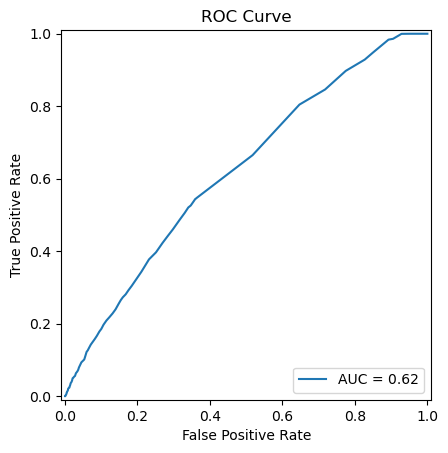

In [116]:

from sklearn.metrics import roc_curve, auc, RocCurveDisplay
import matplotlib.pyplot as plt

fpr, tpr, roc_thresholds = roc_curve(y_test_A, y_pred_probs_A)
roc_auc = auc(fpr, tpr)
print(f"AUC-ROC Score: {roc_auc:.4f}")
print(f"ROC Treshold: {roc_thresholds}")


RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()
plt.title('ROC Curve')
plt.show()



- The ROC Curve shape tells me that the model is doing a strong prediction because the curve is bowed high. 
- An AUC score of 0.62 is a good score. This AUC means the model is not guessing ramdomly, meaning that it has a strong ability to distinguish a restaurant on a critical status and a one who is not before doing any prediction. So, for example, if we pick one restaurant who is on critical and one who is not at random, the model will correctly flag the one on critical to be critical 62% of the time.

### 7) Try a Custom Threshold -- Update the code to fit your threshold and/or variable names from previous cells
Pick a threshold from your curve (e.g., a point balancing your business needs), then recompute metrics.


In [ ]:
y_pred_probs_A = model_A.predict_proba(X_test_A)[:, 1]

# Set the custom threshold to 0.3
threshold = 0.30

# Convert probabilities to final predictions
y_pred_custom = (y_pred_probs_A >= threshold).astype(int)

# Evaluate
from sklearn.metrics import confusion_matrix, classification_report

print("Confusion Matrix:")
print(confusion_matrix(y_test_A, y_pred_custom))

print("\nClassification Report:")
print(classification_report(y_test_A, (y_pred_custom >= 0.5).astype(int)))

Confusion Matrix:
[[   0 3263]
 [   0 3504]]

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3263
           1       0.52      1.00      0.68      3504

    accuracy                           0.52      6767
   macro avg       0.26      0.50      0.34      6767
weighted avg       0.27      0.52      0.35      6767



/opt/miniconda3/envs/data-analysis-env/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/opt/miniconda3/envs/data-analysis-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/data-analysis-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/data-analysis-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:15

## We Share — Reflection (Post 2 short paragraphs)

1) **Curve choice & results:** Which curve did you use (**ROC** or **PR**) and **why** (tie to class balance & business costs)? Report your curve summary (**AUC-ROC** or **Average Precision**) and your chosen extra metric (**precision/recall/F1**) — include threshold (0.5 or custom).  
- I chose the ROC Curve because my dataset is not extremely imbalanced, and the ROC Curve is useful for understanding how well the model separates the two classes overall. It plots the True Positive Rate (Recall) against the False Positive Rate, allowing me to evaluate the model’s performance across all possible thresholds. 
- The AUC-ROC score is 0.62, which means:
    - If we randomly pick one restaurant that is critical and one that is not, the model will correctly rank the critical restaurant higher 62% of the time.”

2) **Stakeholder one-liner:** In plain English: “Using **Score and Cuisine**, our model at the default threshold of **0.50** achieves 53% accuracy and 57% recall. This means that when a restaurant is actually in critical status, our model successfully catches it **57% of the time**. Because missing a critical restaurant has high business risk, I lowered the threshold to 0.30 to increase recall and flag more potential critical cases — even though this means accepting more false alarms.”

> Tip: If the positive class is rare, PR is often more informative than ROC. If classes are balanced or you’re comparing ranking quality across models, AUC-ROC is fine — but still report a confusion matrix at your chosen threshold.
